In [1]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [2]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import cv2

In [3]:
!pip install kaggle

In [4]:
kaggle_credentails = json.load(open("kaggle.json"))

In [5]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [6]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

 kaggle.json  'plantvillage dataset'   plantvillage-dataset.zip   sample_data


In [8]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
colored_data = '/content/plantvillage dataset/color'
print(f'Number of classes: {len(os.listdir(colored_data))}')

Number of classes: 38


In [10]:
img_size = 224
batch_size = 64

In [11]:
data_gen = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    validation_split = 0.2
)

In [12]:
train_generator = data_gen.flow_from_directory(
    colored_data,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.


In [13]:
validation_generator = data_gen.flow_from_directory(
    colored_data,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 10849 images belonging to 38 classes.


In [26]:
input_shape = (224, 224, 3)

base_model = keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
base_model.trainable = False

# Functional API
inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(38, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

callbacks=[early_stopping, model_checkpoint, model_ReduceLROnPlateau]

In [28]:
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    callbacks = callbacks)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 120s 166ms/step - accuracy: 0.5955 - loss: 1.6061 - val_accuracy: 0.9329 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 108s 160ms/step - accuracy: 0.8695 - loss: 0.4355 - val_accuracy: 0.9548 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 107s 157ms/step - accuracy: 0.9018 - loss: 0.3127 - val_accuracy: 0.9613 - val_loss: 0.1229 - learning_rate: 0.0010
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 106s 155ms/step - accuracy: 0.9121 - loss: 0.2784 - val_accuracy: 0.9625 - val_loss: 0.1144 - learning_rate: 0.0010
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 102s 150ms/step - accuracy: 0.9240 - loss: 0.2395 - val_accuracy: 0.9595 - val_loss: 0.1197 - learning_rate: 0.0010
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 106s 156ms/step - accuracy: 0.9287 - loss: 0.2182 - val_accuracy: 0.9675 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 105s 155ms/step - accura

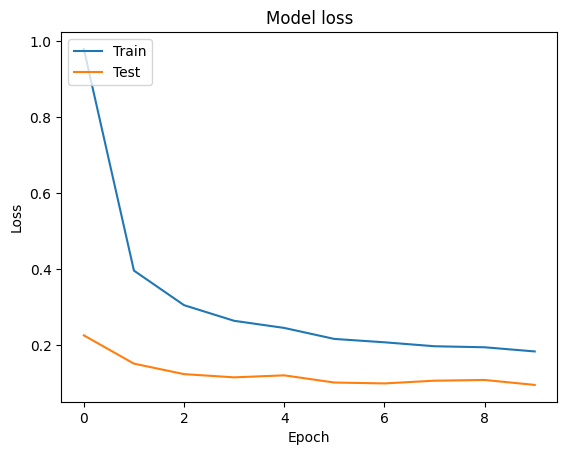

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
def load_and_preprocess_img(image_path, target_size = (224, 224)):
  img = Image.open(image_path)
  img = img.resize(target_size)
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, axis = 0)
  img_array = img_array.astype('float32') / 255.
  return img_array

def predict(model, image_path, class_indices):
  preprocessed_image = load_and_preprocess_img(image_path)
  predictions = model.predict(preprocessed_image)
  predicted_class_index = np.argmax(predictions, axis = 1)[0]
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [31]:
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [32]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [33]:
json.dump(class_indices, open('class_indices.json', 'w'))

In [34]:
model.save('plant_disease_prediction_model.h5')